In [1]:
import os
import logging
from pathlib import Path
import datetime

import collections

import numpy as np
import math
import random
import pandas as pd

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

from neural_compressor.quantization import fit as fit
from neural_compressor.config import PostTrainingQuantConfig, TuningCriterion, AccuracyCriterion

In [2]:
#torch.cuda.empty_cache()

# Logger

In [27]:
log_path = 'results_2_ptq_bn_affine_fasdd_0_01/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.' + 
            'PTQ Quant One Head.' +
            'Neural Compression Quantization.' +
            'BatchNorm Affine Fixed.' +
            'FASDD Dataset Included')

# Config

In [5]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

### DFire

In [6]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the BED Classifier.
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 256.0 #255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 256.0 #255.0
        
        return img, label

# Images and Labels Folders

In [7]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Val dir: {os.listdir(val_dir)}')

Val dir: ['labels', '.ipynb_checkpoints', 'images']


### FASDD

In [8]:
class FASDDDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the BED Classifier.
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - imgs_dir:         path to images folder
        - labels_dir:       path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, imgs_dir, labels_file, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.imgs_dir = imgs_dir
        self.labels_file = labels_file
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = self.__get_labels_list__()
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples  

    def __get_labels_list__(self):
        labels_list = []
        with open(self.labels_file) as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip().split('/')[-1]
                labels_list.append(self.imgs_dir + line)
        return labels_list
            

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for image_path in labels_list:
            fname = Path(image_path).stem
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else: 
                if 'both' in fname:
                    label_array = np.array([1, 1])
                    smoke_fire += 1
                elif 'neither' in fname:
                    label_array = np.array([0, 0])
                    empty += 1
                elif 'smoke' in fname:
                    label_array = np.array([1, 0])
                    only_smoke += 1
                elif 'fire' in fname:
                    label_array = np.array([0, 1])
                    only_fire += 1
                else:
                    print("Wrong Label")
                        
                labels.append(label_array)
                images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 256.0 #255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 256.0 #255.0
        
        return img, label

### FASDD Folders

In [9]:
FASDD_UAV_IMGS_DIR = '../../../datasets/fasdd/fasdd_uav/images/'
FASDD_UAV_TEST_LABELS_FILE = '../../../datasets/fasdd/fasdd_uav/annotations/YOLO_UAV/test.txt'

FASDD_CV_IMGS_DIR = '../../../datasets/fasdd/fasdd_cv/images/'
FASDD_CV_TEST_LABELS_FILE = '../../../datasets/fasdd/fasdd_cv/annotations/YOLO_CV/test.txt'

# Hyperparameters

In [10]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = True
if MODEL == "BED":
    LOAD_MODEL_FILE = "BED_classifier__best_smoke__precision=0.935__epoch=87.pt"

VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

DS_LEN = None

# Dataset Setup

In [11]:
# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

In [12]:
# DFire
print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dfire_dataset = DFireDataset(
    img_h = IMG_H,
    img_w = IMG_W,
    img_dir = VAL_IMG_DIR,
    label_dir = VAL_LABEL_DIR,
    num_classes = N_CLASSES,
    ds_len = DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dfire_dataset)}')
logger.info(f'Test dataset len: {len(val_dfire_dataset)}')


TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


In [13]:
# FASDD UAV

print("\nTEST FASDD UAV dataset")
logger.info(f'TEST FASDD UAV dataset')
val_fasdd_uav_ds = FASDDDataset(
    img_h=IMG_H, 
    img_w=IMG_W, 
    imgs_dir=FASDD_UAV_IMGS_DIR, 
    labels_file=FASDD_UAV_TEST_LABELS_FILE, 
    num_classes=N_CLASSES,
    ds_len=DS_LEN,
    transform=val_transform)
print(f'\nTest FASDD UAV dataset len: {len(val_fasdd_uav_ds)}')
logger.info(f'\nTest FASDD UAV dataset len: {len(val_fasdd_uav_ds)}')


TEST FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 1997
DFire only smoke images: 846
DFire only fire images: 35
DFire smoke and fire images: 1303

Test FASDD UAV dataset len: 4181


In [14]:
# FASDD CV
print("\nTEST FASDD CV dataset")
logger.info("\nTEST FASDD CV dataset")
val_fasdd_cv_ds = FASDDDataset(
    img_h=IMG_H, 
    img_w=IMG_W, 
    imgs_dir=FASDD_CV_IMGS_DIR, 
    labels_file=FASDD_CV_TEST_LABELS_FILE, 
    num_classes=N_CLASSES,
    ds_len=DS_LEN,
    transform=val_transform)
print(f'\nTest FASDD CV dataset len: {len(val_fasdd_cv_ds)}')
logger.info(f'\nTest FASDD CV dataset len: {len(val_fasdd_cv_ds)}')


TEST FASDD CV dataset
DFire Removed wrong images: 0
DFire empty images: 6533
DFire only smoke images: 3902
DFire only fire images: 2091
DFire smoke and fire images: 3358

Test FASDD CV dataset len: 15884


In [15]:
# Concatenate

print("Concatenate Test DFire and FASDD UAV datasets")
logger.info("Concatenate Test DFire and FASDD UAV datasets")
val_ds_concat = torch.utils.data.ConcatDataset((val_dfire_dataset, val_fasdd_uav_ds))
print(f'Test dataset len: {len(val_ds_concat)}')
logger.info(f'Test dataset len: {len(val_ds_concat)}')

print("Concatenate with FASDD CV dataset")
logger.info("Concatenate with FASDD CV dataset")
val_ds = torch.utils.data.ConcatDataset((val_ds_concat, val_fasdd_cv_ds))
print(f'Test dataset len: {len(val_ds)}')
logger.info(f'Test dataset len: {len(val_ds)}')

Concatenate Test DFire and FASDD UAV datasets
Test dataset len: 8487
Concatenate with FASDD CV dataset
Test dataset len: 24371


In [16]:
# LOADERS
val_loader = DataLoader(dataset=val_ds,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)

# Model: BED

In [17]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
    def __create_BED__(self):
        BED_model = nn.Sequential(

            collections.OrderedDict(
                [
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

                    # CNNBlock 224x224
                    ("conv1", nn.Conv2d(self.in_channels, 32, kernel_size=3, stride=1, padding=1,  bias=False)),
                    ("bn1", nn.BatchNorm2d(32)),
                    ("relu1", nn.ReLU()),
                    ("dropout1", nn.Dropout2d(p=0.3)),
        
                    # CNNBlock 112x112
                    ("maxpool2", nn.MaxPool2d(kernel_size=2, stride=2)),
                    ("conv2", nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1,  bias=False)),
                    ("bn2", nn.BatchNorm2d(16)),
                    ("relu2", nn.ReLU()),
                    ("dropout2",nn.Dropout2d(p=0.3)),
        
                    # CNNBlock 56x56
                    ("maxpool3", nn.MaxPool2d(kernel_size=2, stride=2)),
                    ("conv31", nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0,  bias=False)),
                    ("bn31", nn.BatchNorm2d(16)),
                    ("relu31", nn.ReLU()),
                    
                    ("conv32", nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False)),
                    ("bn32", nn.BatchNorm2d(32)),
                    ("relu32", nn.ReLU()),
                    
                    ("conv33", nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False)),
                    ("bn33", nn.BatchNorm2d(32)),
                    ("relu33", nn.ReLU()),
                    
                    ("conv34", nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False)),
                    ("bn34", nn.BatchNorm2d(64)),
                    ("relu34", nn.ReLU()),
        
                    # CNNBlock 28x28
                    ("maxpool4", nn.MaxPool2d(kernel_size=2, stride=2)),
                    ("conv41", nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False)),
                    ("bn41", nn.BatchNorm2d(32)),
                    ("relu41", nn.ReLU()),
                    
                    ("conv42", nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False)),
                    ("bn42", nn.BatchNorm2d(64)),
                    ("relu42", nn.ReLU()),
                    
                    ("conv43", nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False)),
                    ("bn43", nn.BatchNorm2d(32)),
                    ("relu43", nn.ReLU()),
                    
                    ("conv44", nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False)),
                    ("bn44", nn.BatchNorm2d(64)),
                    ("relu44", nn.ReLU()),
                    
                    ("conv45", nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False)),
                    ("bn45", nn.BatchNorm2d(32)),
                    ("relu45", nn.ReLU()),
                    
                    ("conv46", nn.Conv2d(32, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False)),
                    ("bn46", nn.BatchNorm2d(self.last_channels)),
                    ("relu46", nn.ReLU()),
        
                    # Output One Head, 2 Neurons
                    ("avgpool5", nn.AdaptiveAvgPool2d((1, 1))),
                    ("flatten5", nn.Flatten(start_dim=1)),
                    ("dropout5", nn.Dropout(p=0.2)),
                    ("linear51", nn.Linear(in_features=self.last_channels, out_features=16)),
                    ("relu5", nn.ReLU()),
                    ("linear52", nn.Linear(in_features=16, out_features=2)),
                ]
            )
        )
        return BED_model
    

    def __initialize_weights__(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        return x

# Model Setup

In [28]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to('cpu') 
    model.eval()
    quant_model = BED_CLASSIFIER(num_classes=N_CLASSES).to('cpu')
    quant_model.eval()
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device='cpu')
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[-0.0397, -0.1115],
        [-0.0397, -0.1115],
        [-0.0397, -0.1115],
        [-0.0397, -0.1115]], grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (b

# Load Weights

In [29]:
if LOAD_MODEL == False:
    print("Weights must be loaded before Quantization")
    logger.info("Weights must be loaded before Quantization")
    raise SystemExit("Weights must be loaded before Quantization")
else:
    checkpoint = torch.load(LOAD_MODEL_FILE, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    checkpoint_quant = torch.load(LOAD_MODEL_FILE, map_location=torch.device('cpu'))
    quant_model.load_state_dict(checkpoint_quant['model_state_dict'])
    print(f"Loading Model and Quant Model")
    logger.info(f"Loading Model and Quant Model")

Loading Model and Quant Model


# Quantization PTQ

### Metrics

In [30]:
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = 'macro').to('cpu')

### Evaluation function

In [22]:
def eval_func(model):
    model.eval()
    with torch.no_grad():
        for image, label in val_loader:
            #image, label = image.to(DEVICE), label.to(DEVICE)
            output = model(image)
            f1_metric.update(output, label)
        f1_res = f1_metric.compute()
        f1_metric.reset()
    return f1_res.item()

In [23]:
test_f1 = eval_func(quant_model)
print(test_f1)

0.9240025281906128


In [31]:
logger.info(f'Baseline F1 Mean before PTQ: {test_f1}')

### Quantization Code

In [32]:
#conf = PostTrainingQuantConfig()

accuracy_criterion = AccuracyCriterion(tolerable_loss=0.01)
tuning_criterion = TuningCriterion(max_trials=600)
conf = PostTrainingQuantConfig(
    device='cpu',
    approach="static", 
    backend="default", 
    tuning_criterion=tuning_criterion, 
    accuracy_criterion=accuracy_criterion,
    #calibration_sampling_size=512
    calibration_sampling_size=4288
)

q_model = fit(
    quant_model,
    conf,
    calib_dataloader=val_loader,
    eval_func=eval_func)

2024-07-12 17:20:24 [INFO] Start auto tuning.
2024-07-12 17:20:24 [INFO] Execute the tuning process due to detect the evaluation function.
2024-07-12 17:20:24 [INFO] Adaptor has 5 recipes.
2024-07-12 17:20:24 [INFO] 0 recipes specified by user.
2024-07-12 17:20:24 [INFO] 3 recipes require future tuning.
2024-07-12 17:20:24 [INFO] *** Initialize auto tuning
2024-07-12 17:20:24 [INFO] {
2024-07-12 17:20:24 [INFO]     'PostTrainingQuantConfig': {
2024-07-12 17:20:24 [INFO]         'AccuracyCriterion': {
2024-07-12 17:20:24 [INFO]             'criterion': 'relative',
2024-07-12 17:20:24 [INFO]             'higher_is_better': True,
2024-07-12 17:20:24 [INFO]             'tolerable_loss': 0.01,
2024-07-12 17:20:24 [INFO]             'absolute': None,
2024-07-12 17:20:24 [INFO]             'keys': <bound method AccuracyCriterion.keys of <neural_compressor.config.AccuracyCriterion object at 0x7feef0857b80>>,
2024-07-12 17:20:24 [INFO]             'relative': 0.01
2024-07-12 17:20:24 [INFO]    

In [34]:
q_model.save("./results_2_ptq_bn_affine_fasdd_0_01/save_2_bnAffine_fasdd")

2024-07-12 17:30:36 [INFO] Save config file and weights of quantized model to /home/gmoreno/uav/code/quantization/neural_com_intel/results_2_ptq_bn_affine_fasdd_0_01/save_2_bnAffine_fasdd.


In [35]:
print(q_model)

PyTorchFXModel(
  (_model): GraphModule(
    (model): Module(
      (conv1): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.0316382460296154, zero_point=0, padding=(1, 1))
      (dropout1): Dropout2d(p=0.3, inplace=False)
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): QuantizedConvReLU2d(32, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.04425772279500961, zero_point=0, padding=(1, 1))
      (dropout2): Dropout2d(p=0.3, inplace=False)
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv31): QuantizedConvReLU2d(16, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.03361285477876663, zero_point=0)
      (conv32): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.02937215194106102, zero_point=0, padding=(1, 1))
      (conv33): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=(1, 1), scale=0.02526511810719967, zero_point=0)
      (c

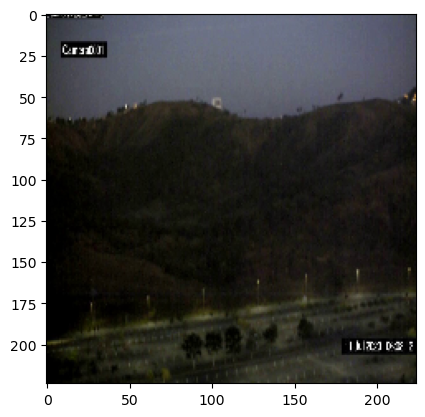

In [36]:
for pic, tag in val_loader:
    global img
    img = pic[40]
    break
plt.imshow(img.permute(1, 2, 0))

In [37]:
out = q_model(img.unsqueeze(dim=0))

In [38]:
out

tensor([[-5.2210, -7.5705]])

In [39]:
for mod in q_model.modules():
    print(mod)

PyTorchFXModel(
  (_model): GraphModule(
    (model): Module(
      (conv1): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.0316382460296154, zero_point=0, padding=(1, 1))
      (dropout1): Dropout2d(p=0.3, inplace=False)
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): QuantizedConvReLU2d(32, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.04425772279500961, zero_point=0, padding=(1, 1))
      (dropout2): Dropout2d(p=0.3, inplace=False)
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv31): QuantizedConvReLU2d(16, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.03361285477876663, zero_point=0)
      (conv32): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.02937215194106102, zero_point=0, padding=(1, 1))
      (conv33): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=(1, 1), scale=0.02526511810719967, zero_point=0)
      (c

# Torchinfo of Model Quantized

In [45]:
from torchinfo import summary

In [47]:
# print(summary(q_model, input_size=(1, 3, IMG_H, IMG_W)))
# logger.info(summary(q_model, input_size=(1, 3, IMG_H, IMG_W)))

# F1 Mean of Model Quantized

In [40]:
test_quant_f1 = eval_func(q_model)
print(test_quant_f1)

0.9191886186599731


In [41]:
logger.info(f'\nPTQ Quant Model F1 Mean: {test_quant_f1}')

# Eval All Metrics

## Change to average None, to see individual results for Smoke and Fire

In [42]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to('cpu')
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to('cpu')
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to('cpu')
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to('cpu')

In [43]:
def eval_all_metrics(model):
    model.eval()
    with torch.no_grad():
        for image, label in val_loader:
            #image, label = image.to(DEVICE), label.to(DEVICE)
            output = model(image)
            precision_metric.update(output, label)
            recall_metric.update(output, label)
            accuracy_metric.update(output, label)
            f1_metric.update(output, label)
        
        pre_res = precision_metric.compute()
        rec_res = recall_metric.compute()
        acc_res = accuracy_metric.compute()
        f1_res = f1_metric.compute()
        
        precision_metric.reset()
        recall_metric.reset()
        accuracy_metric.reset()
        f1_metric.reset()
        
    return {
        'Accuracy': acc_res,
        'Precision': pre_res,
        'Recall': rec_res,
        'F1-score': f1_res
    }
        

In [44]:
quant_metrics = eval_all_metrics(q_model)
ori_metrics = eval_all_metrics(model)

In [48]:
metrics_data = np.zeros((2, 8))
for i, ((kq, vq), (k, v)) in enumerate(zip(quant_metrics.items(), ori_metrics.items())):
    metrics_data[0, 2*i] = np.round(100*v[0].item(), decimals=2)
    metrics_data[0, 2*i+1] = np.round(100*v[1].item(), decimals=2)
    metrics_data[1, 2*i] = np.round(100*vq[0].item(), decimals=2)
    metrics_data[1, 2*i+1] = np.round(100*vq[1].item(), decimals=2)
metrics_data

array([[91.37, 96.14, 93.51, 91.28, 87.8 , 97.4 , 90.56, 94.24],
       [90.95, 95.76, 92.61, 90.48, 87.82, 97.13, 90.15, 93.69]])

In [49]:
idx = ['Original', 'Quantized']
cols = pd.MultiIndex.from_product([['Accuracy', 'Precision', 'Recall', 'F1-Score'], ['Smoke', 'Fire']])

In [50]:
df = pd.DataFrame(metrics_data, index=idx, columns=cols)
df

Accuracy        Precision        Recall        F1-Score       
             Smoke   Fire     Smoke   Fire  Smoke   Fire    Smoke   Fire
Original     91.37  96.14     93.51  91.28  87.80  97.40    90.56  94.24
Quantized    90.95  95.76     92.61  90.48  87.82  97.13    90.15  93.69

In [30]:
#q_conv = torch.ao.quantization.convert(q_model)
#q_conv= torch.ao.quantization.quantize_fx.convert_fx(q_model)

In [31]:
#print(q_model.state_dict())

In [51]:
graph_ex = q_model.graph_info

In [52]:
graph_ex

{'model.conv1': 'Conv2d',
 'model.conv2': 'Conv2d',
 'model.conv31': 'Conv2d',
 'model.conv32': 'Conv2d',
 'model.conv33': 'Conv2d',
 'model.conv34': 'Conv2d',
 'model.conv41': 'Conv2d',
 'model.conv42': 'Conv2d',
 'model.conv43': 'Conv2d',
 'model.conv44': 'Conv2d',
 'model.conv45': 'Conv2d',
 'model.conv46': 'Conv2d',
 'model.dropout5': 'Dropout',
 'model.linear51': 'Linear',
 'model.linear52': 'Linear'}

In [53]:
q_model.q_config

{'op': OrderedDict([(('model.conv1', 'Conv2d'),
               {'weight': {'dtype': 'int8',
                 'scheme': 'sym',
                 'granularity': 'per_channel',
                 'algorithm': 'minmax'},
                'activation': {'dtype': 'uint8',
                 'quant_mode': 'static',
                 'scheme': 'asym',
                 'granularity': 'per_tensor',
                 'algorithm': 'kl',
                 'scale': 0.0316382460296154,
                 'zero_point': 0}}),
              (('model.conv2', 'Conv2d'),
               {'weight': {'dtype': 'int8',
                 'scheme': 'sym',
                 'granularity': 'per_channel',
                 'algorithm': 'minmax'},
                'activation': {'dtype': 'uint8',
                 'quant_mode': 'static',
                 'scheme': 'asym',
                 'granularity': 'per_tensor',
                 'algorithm': 'kl',
                 'scale': 0.04425772279500961,
                 'zero_point': 0}}

In [54]:
q_model.is_quantized

True

In [55]:
q_model.get_all_weight_names

<bound method PyTorchBaseModel.get_all_weight_names of PyTorchFXModel(
  (_model): GraphModule(
    (model): Module(
      (conv1): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.0316382460296154, zero_point=0, padding=(1, 1))
      (dropout1): Dropout2d(p=0.3, inplace=False)
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): QuantizedConvReLU2d(32, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.04425772279500961, zero_point=0, padding=(1, 1))
      (dropout2): Dropout2d(p=0.3, inplace=False)
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv31): QuantizedConvReLU2d(16, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.03361285477876663, zero_point=0)
      (conv32): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.02937215194106102, zero_point=0, padding=(1, 1))
      (conv33): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=(1

In [56]:
sparse = q_model.report_sparsity()

In [57]:
sparse

(                                            Name           Shape  NNZ (dense)  \
 0                             model.conv1.weight   [32, 3, 3, 3]          861   
 1                             model.conv2.weight  [16, 32, 3, 3]         4550   
 2                            model.conv31.weight  [16, 16, 1, 1]          252   
 3                            model.conv32.weight  [32, 16, 3, 3]         4407   
 4                            model.conv33.weight  [32, 32, 1, 1]          988   
 5                            model.conv34.weight  [64, 32, 3, 3]        17665   
 6                            model.conv41.weight  [32, 64, 1, 1]         1911   
 7                            model.conv42.weight  [64, 32, 3, 3]        17670   
 8                            model.conv43.weight  [32, 64, 1, 1]         2033   
 9                            model.conv44.weight  [64, 32, 3, 3]        16553   
 10                           model.conv45.weight  [32, 64, 1, 1]         1267   
 11             

# ONNX Export

In [59]:
import onnxruntime

In [60]:
from neural_compressor.config import Torch2ONNXConfig

int8_onnx_config = Torch2ONNXConfig(
    dtype="int8",
    opset_version=14,
    quant_format="QOperator",  # or QDQ
    example_inputs=img.unsqueeze(dim=0), #torch.randn(1, 3, 224, 224),
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
)
q_model.export("int8-model-bnAffine-fasdd.onnx", int8_onnx_config)

2024-07-12 17:52:24 [INFO] ********************************************************************
2024-07-12 17:52:24 [INFO] The INT8 ONNX Model exported to path: int8-model-bnAffine-fasdd.onnx
2024-07-12 17:52:24 [INFO] ********************************************************************


In [45]:
for pic, lab in val_loader:
    print(torch.min(pic))
    print(torch.max(pic))
    break

tensor(0.)
tensor(1.)
